In [1]:
# class RobotabilityGraph that inherits from Graph class 
import os
import sys 
sys.path.append("/share/ju/urban-fingerprinting")

import osmnx as ox 
import geopandas as gpd 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from glob import glob 
from tqdm import tqdm 

from shapely import wkt, LineString 

import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show 


from src.utils.logger import setup_logger 

logger = setup_logger('robotability-score')
logger.setLevel("INFO")
logger.info("Modules initialized.")

WGS='EPSG:4326'
PROJ='EPSG:2263'



2024-09-04 17:09:57 - robotability-score - INFO - Modules initialized.


In [2]:
def min_max_normalize(series: pd.Series) -> pd.Series:
    """
    Normalize the input pandas Series using min-max normalization.

    Parameters:
    series (pd.Series): The pandas Series to normalize.

    Returns:
    pd.Series: A new pandas Series with values normalized between 0 and 1.
    """
    min_val = series.min()
    max_val = series.max()
    
    if min_val == max_val:
        # Avoid division by zero; if all values are the same, return 0 for all elements
        return pd.Series([0.0] * len(series), index=series.index)
    
    return (series - min_val) / (max_val - min_val)

In [3]:
dataset = pd.read_csv("../data/processed/score_dataset.csv", engine='pyarrow')
dataset = gpd.GeoDataFrame(dataset, geometry=dataset['geometry'].apply(wkt.loads), crs=PROJ)

In [4]:
len(dataset.index)

2553615

In [5]:
dataset.columns.values

array(['', '5g_technology', '5g_mindown', '5g_minup', '5g_environmnt',
       '5g_h3_res9_id', '4g_technology', '4g_mindown', '4g_minup',
       '4g_environmnt', '4g_h3_res9_id', 'SOURCE_ID', 'SHAPE_Leng',
       'SHAPE_Area', 'SHAPE_Width', 'geometry', 'point_index',
       'ft_above_sea', 'n_cameras_median', 'Unnamed: 0',
       'SOURCE_ID_street_furniture', 'SHAPE_Leng_street_furniture',
       'SHAPE_Area_street_furniture', 'SHAPE_Width_street_furniture',
       'geometry_street_furniture', 'bus_stop_count', 'trash_can_count',
       'linknyc_count', 'citybench_count',
       'bicycle_parking_shelter_count', 'bicycle_rack_count',
       'tree_count', 'newsstand_count', 'parking_meter_count',
       'hydrant_count', 'street_sign_count', 'alarm_call_box_count',
       'scaffolding_permit_count', 'clutter', 'ZONEDIST', 'Shape_Leng',
       'Shape_Area', 'distance_to_nearest_station', 'CURBRAMP_count',
       'RAISEDCROSSWALK_count', 'boro_cd', 'shape_area', 'shape_leng',
       'cd_co

In [6]:
dataset.isna().sum()  

                                       0
5g_technology                       1331
5g_mindown                          1331
5g_minup                            1331
5g_environmnt                       1331
                                    ... 
sip_corridors_count                 2394
barnes_intersections_count          2394
leading_ped_intervals_count         2394
highest_bike_lane_facility_class    2394
num_peds_involved_in_collision      2394
Length: 78, dtype: int64

In [7]:
FEATURES = { 
    'sidewalk_width': 'Sidewalk Width',
    'pedestrian_density': 'Pedestrian Density',
    'street_furniture_density': 'Density of Street Furniture',
    'sidewalk_roughness': 'Sidewalk Roughness',
    'surface_condition': 'Surface Condition',
    'communication_infrastructure': 'Wireless Communication Infrastructure',
    'slope_gradient': 'Slope Gradient',
    'charging_station_proximity': 'Proximity to Charging Stations',
    'local_attitudes': 'Local Attitudes Towards Robots',
    'curb_ramp_availability': 'Curb Ramp Availability',
    'weather_conditions': 'Weather Conditions',
    'crowd_dynamics': 'Crowd Dynamics',
    'traffic_management': 'Traffic Management Systems',
    'surveillance_coverage': 'Surveillance Coverage',
    'zoning_laws': 'Zoning Laws and Regulation',
    'bike_lane_availability': 'Bike Lane Availability',
    'street_lighting': 'Street Lighting',
    'shade_availability': 'Existence of Shade',
    'gps_signal_strength': 'GPS Signal Strength',
    'pedestrian_flow': 'Pedestrian Flow',
    'bicycle_traffic': 'Bicycle Traffic',
    'vehicle_traffic': 'Vehicle Traffic',
    'digital_map_existence': 'Existence of Detailed Digital Maps',
    'intersection_safety': 'Intersection Safety'
}



In [8]:
len(FEATURES)

24

In [9]:
# which 

In [10]:
# read csv as dict and store in WEIGHTS 
WEIGHTS = pd.read_csv("../survey_processing/feature_weights.csv", index_col=0).to_dict()['Weight']
WEIGHTS

{'sidewalk_width': 0.0666522433962001,
 'pedestrian_density': 0.0947069709593629,
 'street_furniture_density': 0.0664828559438847,
 'sidewalk_roughness': 0.0476301132910382,
 'surface_condition': 0.0765110540640444,
 'communication_infrastructure': 0.0610756705610995,
 'slope_gradient': 0.0545833771886842,
 'charging_station_proximity': 0.0257457800450019,
 'curb_ramp_availability': 0.0604760235101482,
 'crowd_dynamics': 0.0728095551221969,
 'traffic_management': 0.0446720054980464,
 'surveillance_coverage': 0.0256561388534967,
 'zoning_laws': 0.0456798510422274,
 'bike_lane_availability': 0.0198643058288491,
 'gps_signal_strength': 0.0481144417826519,
 'bicycle_traffic': 0.0305681405466959,
 'vehicle_traffic': 0.0444280939118959,
 'digital_map_existence': 0.0460578592748008,
 'intersection_safety': 0.068285519179674}

In [11]:
# get sum of weights 
sum(WEIGHTS.values())

0.9999999999999991

In [12]:
features = pd.DataFrame()

In [13]:
# add geometry to features
features['geometry'] = dataset['geometry']
# add point index to features 
features['point_index'] = dataset['point_index']

### Sidewalk Width 

In [14]:
def PREPROCESS_sidewalk_width(col): 
    # softmax the sidewalk width so that it is between 0 and 1
    col = min_max_normalize(col)

    return col

dataset['sidewalk_width'] = PREPROCESS_sidewalk_width(dataset['SHAPE_Width'])

In [15]:
def COMPUTE_sidewalk_width(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['sidewalk_width']


In [16]:
features['sidewalk_width'] = COMPUTE_sidewalk_width(dataset['sidewalk_width'])

### Pedestrian Density 

In [17]:
def PREPROCESS_pedestrian_density(col):
    # softmax the pedestrian density so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['pedestrian_density'] = PREPROCESS_pedestrian_density(dataset['TRAFFIC_Pedestrian'])

In [18]:
def COMPUTE_pedestrian_density(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['pedestrian_density']

In [19]:
features['pedestrian_density'] = COMPUTE_pedestrian_density(dataset['pedestrian_density'])

### Street Furniture Density 

In [20]:
def PREPROCESS_street_furniture_density(col):
    # softmax the street furniture density so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['street_furniture_density'] = PREPROCESS_street_furniture_density(dataset['clutter'])

In [21]:
def COMPUTE_street_furniture_density(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['street_furniture_density']

features['street_furniture_density'] = COMPUTE_street_furniture_density(dataset['street_furniture_density'])

### Sidewalk Roughness 

In [22]:
# SKIP preprocessing, as all values are already 1

In [23]:
 def COMPUTE_sidewalk_roughness(col=None, WEIGHTS=WEIGHTS): 
    return 1 * WEIGHTS['sidewalk_roughness']


In [24]:
features['sidewalk_roughness'] = COMPUTE_sidewalk_roughness()

# check out accessmap for this 

### Surface Condition 

In [25]:
def PREPROCESS_surface_condition(col):
    col = min_max_normalize(col)
    col = col.fillna(col.mean())
    return col

dataset['surface_condition'] = PREPROCESS_surface_condition(dataset['sidewalk_quality'])

In [26]:
def COMPUTE_surface_condition(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['surface_condition']

features['surface_condition'] = COMPUTE_surface_condition(dataset['surface_condition'])

### Wireless Communication Infrastructure 

In [27]:
# SKIP preprocessing, as all values are already 0 or 1

In [28]:
def COMPUTE_communication_infrastructure(row, WEIGHTS=WEIGHTS): 
    return (1 if (row['4g_minup'] > 0 and row['4g_mindown'] > 0) else 0) * WEIGHTS['communication_infrastructure']

In [29]:
features['communication_infrastructure'] = dataset.apply(lambda row: COMPUTE_communication_infrastructure(row), axis=1)

### Slope Gradient 

In [30]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm

def POPULATE_slope_gradient_optimized_with_progress(dataset, WEIGHTS=WEIGHTS):
    # Convert geometries to numpy arrays for faster distance computation
    coords = np.array([[geom.x, geom.y] for geom in dataset['geometry']])
    tree = cKDTree(coords)

    # Initialize an array for slope gradients
    slope_gradients = np.zeros(len(dataset))

    # Precompute distances for each point
    for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
        # Get indices of nearest neighbors within 50 units, excluding the point itself
        distances, indices = tree.query(coords[i], k=10, distance_upper_bound=50)
        
        # Remove invalid indices (those equal to len(coords))
        valid_mask = (indices != len(coords)) & (indices != i)
        valid_indices = indices[valid_mask]
        valid_distances = distances[valid_mask]
        
        # Compute slope gradients
        if len(valid_indices) > 0:
            height_diffs = np.abs(dataset['ft_above_sea'].iloc[valid_indices] - row['ft_above_sea'])
            slopes = height_diffs / valid_distances
            # take absolute value of slope
            slopes = np.abs(slopes)
            slope_gradients[i] = slopes.mean() * WEIGHTS['slope_gradient']

    return slope_gradients

# Apply the optimized function with progress monitoring
dataset['slope_gradient'] = POPULATE_slope_gradient_optimized_with_progress(dataset)

# take the absolute value of the slope

100%|██████████| 2553615/2553615 [18:56<00:00, 2247.33it/s]


In [31]:
def POSTPROCESS_slope_gradient(col): 
    # softmax the slope gradient so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['slope_gradient'] = POSTPROCESS_slope_gradient(dataset['slope_gradient'])

In [32]:
def COMPUTE_slope_gradient(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['slope_gradient']


In [33]:
features['slope_gradient'] = COMPUTE_slope_gradient(dataset['slope_gradient'])

<Axes: >

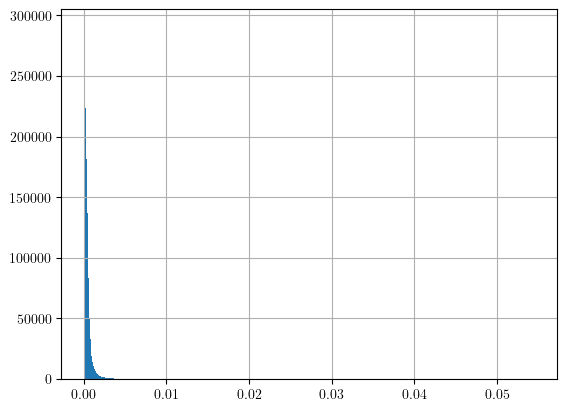

In [34]:
# log the distribution here, as this one might be tricky 
features['slope_gradient'].hist(bins=1000)

### Charging Station Proximity 

In [35]:
# convert to col-level function 
def POPULATE_charging_station_proximity(col, RANGE=max(dataset['distance_to_nearest_station'])): 
    return (RANGE-col)/RANGE

In [36]:
dataset['charging_station_proximity'] = POPULATE_charging_station_proximity(dataset['distance_to_nearest_station'])

In [37]:
def POSTPROCESS_charging_station_proximity(col):
    # softmax the charging station proximity so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['charging_station_proximity'] = POSTPROCESS_charging_station_proximity(dataset['charging_station_proximity'])

In [38]:
def COMPUTE_charging_station_proximity(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['charging_station_proximity']

features['charging_station_proximity'] = COMPUTE_charging_station_proximity(dataset['charging_station_proximity'])

### Local Attitudes Towards Robots 

**SKIP DUE TO LACK OF DATA** 

### Curb Ramp Availability 

In [39]:
def PREPROCESS_curb_ramp_availability(col): 
    col = min_max_normalize(col)
    return col

dataset['curb_ramp_availability'] = PREPROCESS_curb_ramp_availability(dataset['CURBRAMP_count'])

In [40]:
def COMPUTE_curb_ramp_availability(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['curb_ramp_availability']

features['curb_ramp_availability'] = COMPUTE_curb_ramp_availability(dataset['curb_ramp_availability'])

### Weather Conditions 

** Skip due to hyperlocal/temporal nature of weather conditions ** 

### Crowd Dynamics 

In [41]:
def zonedist_to_indicator(row): 
    
    if row:

        if row.startswith('M'): 
            return 10
        elif row.startswith('R'):
            return 5
        elif row.startswith('C'): 
            return 0
        else: 
            return 2 
    else:
        return 0


def POPULATE_crowd_dynamics(col): 
    return col.apply(zonedist_to_indicator)

dataset['crowd_dynamics'] = POPULATE_crowd_dynamics(dataset['ZONEDIST'])

In [42]:
def POSTPROCESS_crowd_dynamics(col):
    # softmax the crowd dynamics so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['crowd_dynamics'] = POSTPROCESS_crowd_dynamics(dataset['crowd_dynamics'])

In [43]:
def COMPUTE_crowd_dynamics(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['crowd_dynamics']

features['crowd_dynamics'] = COMPUTE_crowd_dynamics(dataset['crowd_dynamics'])

### Traffic Management 

In [44]:
def POPULATE_traffic_management(df, WEIGHTS=WEIGHTS): 
    return  (df['in_slow_zone'] + df['turn_traffic_calming_count'] + df['sip_intersections_count'] + df['sip_corridors_count'] + df['barnes_intersections_count'] + df['leading_ped_intervals_count']).fillna(0)

dataset['traffic_management'] = POPULATE_traffic_management(dataset)





In [45]:
def POSTPROCESS_traffic_management(col): 
    # softmax the traffic management so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['traffic_management'] = POSTPROCESS_traffic_management(dataset['traffic_management'])
    

In [46]:
def COMPUTE_traffic_management(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['traffic_management']

features['traffic_management'] = COMPUTE_traffic_management(dataset['traffic_management'])


### Surveillance Coverage 

In [47]:
def PREPROCESS_surveillance_coverage(col): 
    # softmax the surveillance coverage so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['surveillance_coverage'] = PREPROCESS_surveillance_coverage(dataset['n_cameras_median'])

In [48]:
def COMPUTE_surveillance_coverage(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['surveillance_coverage']

features['surveillance_coverage'] = COMPUTE_surveillance_coverage(dataset['surveillance_coverage'])
    

### Zoning Laws & Regulations

In [49]:
def PREPROCESS_zoning_laws(col): 
    # softmax the zoning laws so that it is between 0 and 1
    col = min_max_normalize(col)
    col = col.fillna(0)
    return col

dataset['zoning_laws'] = PREPROCESS_zoning_laws(dataset['avg_speed_limit'])



In [50]:
def COMPUTE_zoning_laws(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['zoning_laws']

features['zoning_laws'] = COMPUTE_zoning_laws(dataset['zoning_laws'])

### Bike Lane Availability 

In [51]:
def PREPROCESS_bike_lane_availability(col):
    # softmax the bike lane availability so that it is between 0 and 1
    col = min_max_normalize(col)
    col = col.fillna(0)
    return col

dataset['bike_lane_availability'] = PREPROCESS_bike_lane_availability(dataset['highest_bike_lane_facility_class'])

In [52]:
def COMPUTE_bike_lane_availability(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['bike_lane_availability']

features['bike_lane_availability'] = COMPUTE_bike_lane_availability(dataset['bike_lane_availability'])


### Street Lighting

** Skip due to lack of data ** 

### Shade Availability 

**Come Back**

### GPS Signal Strength

In [53]:
# SKIP preprocessing, as all values are already 0 or 1

In [54]:
def COMPUTE_gps_signal_strenth(col=None, WEIGHTS=WEIGHTS): 
    return 1 * WEIGHTS['gps_signal_strength']

features['gps_signal_strength'] = COMPUTE_gps_signal_strenth()

### Pedestrian Flow 

** Skip due to lack of data ** 

### Bicycle Traffic 

In [55]:
def PREPROCESS_bicycle_traffic(col):
    # softmax the bicycle traffic so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['bicycle_traffic'] = PREPROCESS_bicycle_traffic(dataset['TRAFFIC_Bike'])


In [56]:
def COMPUTE_bicycle_traffic(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['bicycle_traffic']

features['bicycle_traffic'] = COMPUTE_bicycle_traffic(dataset['bicycle_traffic'])

### Vehicle Traffic 

In [57]:
def PREPROCESS_vehicle_traffic(col):
    # softmax the vehicle traffic so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['vehicle_traffic'] = PREPROCESS_vehicle_traffic(dataset['TRAFFIC_Car'])


In [58]:
def COMPUTE_vehicle_traffic(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['vehicle_traffic']

features['vehicle_traffic'] = COMPUTE_vehicle_traffic(dataset['vehicle_traffic'])

### Existence of Detailed Digital Map 

In [59]:
def COMPUTE_ddm():
    return 1 * WEIGHTS['digital_map_existence']

In [60]:
features['digital_map_existence'] = COMPUTE_ddm()

### Intersection Safety 

In [61]:
def PREPROCESS_intersection_safety(col):
    # softmax the intersection safety so that it is between 0 and 1
    col = col.fillna(0).astype(int)
    col = min_max_normalize(col)
    return col

dataset['intersection_safety'] = PREPROCESS_intersection_safety(dataset['num_peds_involved_in_collision'])

In [62]:
def COMPUTE_intersection_safety(col, WEIGHTS=WEIGHTS):

    return col * WEIGHTS['intersection_safety']

features['intersection_safety'] = COMPUTE_intersection_safety(dataset['intersection_safety'])

## SANITY CHECKS

In [63]:
# assert that all values of all columns except geometry and pouint_index are 0-1
for col in features.columns: 
    if col not in ['geometry', 'point_index']: 
        assert features[col].min() >= 0 and features[col].max() <= 1

In [64]:
features.isna().sum() 

geometry                             0
point_index                          0
sidewalk_width                       0
pedestrian_density              388970
street_furniture_density             7
sidewalk_roughness                   0
surface_condition                    0
communication_infrastructure         0
slope_gradient                       0
charging_station_proximity           0
curb_ramp_availability               0
crowd_dynamics                       0
traffic_management                   0
surveillance_coverage                0
zoning_laws                          0
bike_lane_availability               0
gps_signal_strength                  0
bicycle_traffic                 388970
vehicle_traffic                 388970
digital_map_existence                0
intersection_safety                  0
dtype: int64

In [65]:
len(features.columns)

21

In [66]:
# which FEATURES aren't a column in features? 
print(set(FEATURES.keys()) - set(features.columns))


{'weather_conditions', 'shade_availability', 'street_lighting', 'pedestrian_flow', 'local_attitudes'}


In [67]:
POLARITIES = { 
    'sidewalk_width': 1,
    'pedestrian_density': -1,
    'street_furniture_density': -1, 
    'sidewalk_roughness': -1,
    'surface_condition': 1,
    'communication_infrastructure': 1,
    'slope_gradient': -1,
    'charging_station_proximity': 1,
    'local_attitudes': 1,
    'curb_ramp_availability': 1,
    'weather_conditions': 1,
    'crowd_dynamics': 1,
    'traffic_management': 1,
    'surveillance_coverage': 1,
    'zoning_laws': 1,
    'bike_lane_availability': 1,
    'street_lighting': 1,
    'shade_availability': 1,
    'gps_signal_strength': 1,
    'pedestrian_flow': -1,
    'bicycle_traffic': -1,
    'vehicle_traffic': -1,
    'digital_map_existence': 1,
    # num incidents, so more is worse
    'intersection_safety': -1,
}

In [68]:
# score is the aggregation of all features 
features['score'] = features.drop(columns=['geometry', 'point_index']).mul(pd.Series(POLARITIES)).sum(axis=1)



In [69]:
features.describe([0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99, 0.999]) 

,point_index,sidewalk_width,pedestrian_density,street_furniture_density,sidewalk_roughness,surface_condition,communication_infrastructure,slope_gradient,charging_station_proximity,curb_ramp_availability,...,traffic_management,surveillance_coverage,zoning_laws,bike_lane_availability,gps_signal_strength,bicycle_traffic,vehicle_traffic,digital_map_existence,intersection_safety,score
count,2.553615e+06,2.553615e+06,2.164645e+06,2.553608e+06,2.553615e+06,2.553615e+06,2.553615e+06,2.553615e+06,2.553615e+06,2.553615e+06,...,2.553615e+06,2.553615e+06,2.553615e+06,2.553615e+06,2.553615e+06,2.164645e+06,2.164645e+06,2.553615e+06,2.553615e+06,2.553615e+06
mean,1.275310e+06,8.515820e-03,3.513633e-03,5.065583e-03,4.763011e-02,7.025676e-02,6.095522e-02,3.909275e-04,2.125028e-02,1.693575e-03,...,6.592913e-04,7.015008e-04,1.965975e-02,1.782016e-03,4.811444e-02,1.585611e-04,1.365708e-02,4.605786e-02,7.056343e-05,2.474326e-01
std,7.365337e+05,2.471739e-03,5.948671e-03,1.138780e-02,2.844947e-16,8.887597e-03,2.709598e-03,5.352830e-04,5.040983e-03,4.877835e-03,...,1.705515e-03,2.043351e-03,8.168743e-03,4.727454e-03,1.804113e-16,4.886325e-04,4.842012e-03,3.191892e-16,6.270052e-04,2.610688e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.763011e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.811444e-02,0.000000e+00,0.000000e+00,4.605786e-02,0.000000e+00,6.572753e-02
0.1%,2.553614e+03,2.282018e-03,0.000000e+00,0.000000e+00,4.763011e-02,0.000000e+00,0.000000e+00,0.000000e+00,6.934848e-04,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.811444e-02,0.000000e+00,0.000000e+00,4.605786e-02,0.000000e+00,1.324890e-01
1%,2.553514e+04,3.315140e-03,0.000000e+00,0.000000e+00,4.763011e-02,3.062223e-02,6.107567e-02,0.000000e+00,5.381231e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.811444e-02,0.000000e+00,1.931656e-03,4.605786e-02,0.000000e+00,1.646795e-01
2.5%,6.379535e+04,4.094715e-03,0.000000e+00,0.000000e+00,4.763011e-02,5.447908e-02,6.107567e-02,0.000000e+00,8.447401e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.811444e-02,0.000000e+00,3.863313e-03,4.605786e-02,0.000000e+00,1.834912e-01
5%,1.275747e+05,5.086502e-03,0.000000e+00,0.000000e+00,4.763011e-02,5.763922e-02,6.107567e-02,0.000000e+00,1.123241e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.811444e-02,0.000000e+00,5.207073e-03,4.605786e-02,0.000000e+00,1.996729e-01
10%,2.550944e+05,5.919378e-03,0.000000e+00,0.000000e+00,4.763011e-02,6.133347e-02,6.107567e-02,4.878254e-05,1.399586e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.811444e-02,0.000000e+00,7.082740e-03,4.605786e-02,0.000000e+00,2.150663e-01
25%,6.371125e+05,6.988123e-03,1.202628e-04,0.000000e+00,4.763011e-02,6.816561e-02,6.107567e-02,1.217538e-04,1.852979e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,2.283993e-02,0.000000e+00,4.811444e-02,0.000000e+00,1.043094e-02,4.605786e-02,0.000000e+00,2.368136e-01


In [70]:
features[['point_index','geometry','score']].to_csv("../data/processed/score_nyc.csv")

In [ ]:
features.to_csv("../data/processed/robotability_features.csv", index=False)